This notebook uses the k-nearests neighbors algorithm for classifying samples of the MNIST dataset.
Different metrics are used and compared to each other.

In [1]:
using MLDatasets # for loading the MNIST data

using Statistics: mean, std, var
using Distances

using ProgressMeter # to show a progress bar when calculating

# libraries for plotting
using Plots
using StatPlots
using LaTeXStrings
;

┌ Info: Precompiling StatPlots [60ddc479-9b66-56df-82fc-76a74619b69c]
└ @ Base loading.jl:1189


In [2]:
train_x, train_y = MNIST.traindata()
train_x = reshape(train_x, (28*28, :)) / 255.0

test_x, test_y = MNIST.testdata()
test_x = reshape(test_x, (28*28, :)) / 255.0
;

Remove features that have zero variance. Data normalization leads to
worse results in this case, so it is not used.

In [3]:
good_features = findall(x -> x ≉ 0.0, vec(var(train_x, dims=2)))
train_x = train_x[good_features, :]
test_x = test_x[good_features, :]

#=
function normalize!(X)
    μ = mean(X, dims=2)
    σ = std(X, dims=2)
    return normalize!(X, μ, σ)
end

function normalize!(X, μ, σ)
    X .-= μ
 #   X ./= σ
    return μ, σ
end

μ, σ = normalize!(train_x)
normalize!(test_x, μ, σ)
=#
;

This is a simple knn alorithm that calculates the k nearests neighbors in sorted order for a bunch of query points. It does not make use of advanced features such as kd-trees.
There is a Julia library [NearestNeighbors.jl](https://github.com/KristofferC/NearestNeighbors.jl) that can do k-nearest neighbors, but it does not work with non-metrics such as the cosine distance.

In [4]:
function knn_sample!(distfunc, 
                     points::AbstractMatrix{T},
                     query::AbstractVector{T},
                     k,
                     result, distsbuffer=Vector{Float64}(undef, k)
                     ) where {T}
    dists = distsbuffer
    fill!(dists, Inf)
    @inbounds for i in 1:size(points, 2)
        p = @view points[:, i]
        r = evaluate(distfunc, p, query)
        if r <= dists[end]
            for j in 1:k
                if r <= dists[j]
                    @simd for l = k:-1:(j+1)
                        result[l] = result[l - 1]
                        dists[l] = dists[l - 1]
                    end
                    result[j] = i
                    dists[j] = r
                    break
                end
            end
        end
    end
end

function knn(distfunc, points::AbstractMatrix{T}, queries::AbstractMatrix{T}, k) where {T}
    @assert size(points, 1) == size(queries, 1)
    @assert size(points, 2) >= k >= 0
    
    n = size(queries, 2)
    result = [Vector{Int}(undef, k) for _ in 1:n]
    distsbuffer=Vector{Float64}(undef, k)
    @showprogress 0.1 "knn $(typeof(distfunc)): " for i = 1:n
        @inbounds q = @view queries[:,i]
        @inbounds knn_sample!(distfunc, points, q, k, result[i], distsbuffer)
    end
    return result
end
;

Given a query point and the labels of the k nearest neighbors, we assign the most frequent label to that query point. Then we compare with the real label and assign a unit cost for calculating the wrong label.

In [5]:
function most_frequent(a)
    result = nothing
    freq = Dict{eltype(a), Int}()
    for i in a
        x = get!(freq, i, 0)
        freq[i] = x + 1
    end
    largest_freq = 0
    for (k, v) in freq
        if v > largest_freq
            largest_freq = v
            result = k
     #   elseif v == largest_freq
      #      result = nothing
        end
    end
    return result
end

function cost(labels, labels_nn, k)
    n = size(labels_nn, 1)

    result = 0
    for i = 1:n
        if most_frequent(labels_nn[i, 1:k]) != labels[i]
            result += 1
        end
    end
    return result / n
end
;

This function takes a distance `dist` and labeled training and test sets `train` and `test` respectively. It then creates a knn classifier for that distance and evaluates it on both the training set and the test set for up to `num_ks` neighbors. The number of points that are actually evaluated can be restricted with the parameter `num_evaluations`. It returns two vectors of length `num_ks` that contain the calculated costs for the training set and the test set for 1 up to `num_ks` neighbors.

In [6]:
function evaluate_distance(dist, train, test, num_ks, num_evaluations=typemax(Int))
    train_x, train_y = train
    test_x, test_y = test
    
    n = min(num_evaluations, size(train_x, 2))
    nn_indices = knn(dist, train_x, train_x[:, 1:n], num_ks)
    train_nn_y = [train_y[nn_indices[i][k]] for i in 1:n, k in 1:num_ks]
    train_costs = [cost(train_y, train_nn_y, k) for k in 1:num_ks]
    
    n = min(num_evaluations, size(test_x, 2))
    nn_indices = knn(dist, train_x, test_x[:, 1:n], num_ks)
    test_nn_y = [train_y[nn_indices[i][k]] for i in 1:n, k in 1:num_ks]
    test_costs = [cost(test_y, test_nn_y, k) for k in 1:num_ks]
    
    return train_costs, test_costs
end
;

Here we run `evaluate dstance` on six different distances. For larger values of `num_evaluations` and `num_ks` this can take a very long time.

In [7]:
num_evaluations = 5000 # the number of samples from train/test on which we evalate the cost
num_ks = 15            # the maximum number of neighbors that we consider

train = (train_x, train_y)
test = (test_x, test_y)
costs_cosine = evaluate_distance(CosineDist(), train, test, num_ks, num_evaluations)
costs_euclidean = evaluate_distance(Euclidean(), train, test, num_ks, num_evaluations)
costs_chebyshev = evaluate_distance(Chebyshev(), train, test, num_ks, num_evaluations)
costs_chisq = evaluate_distance(ChiSqDist(), train, test, num_ks, num_evaluations)
costs_cityblock = evaluate_distance(Cityblock(), train, test, num_ks, num_evaluations)
costs_spannorm= evaluate_distance(SpanNormDist(), train, test, num_ks, num_evaluations)
;

knn CosineDist: 100%|███████████████████████████████████| Time: 0:04:40
knn CosineDist: 100%|███████████████████████████████████| Time: 0:04:29
knn Euclidean: 100%|████████████████████████████████████| Time: 0:01:36
knn Euclidean: 100%|████████████████████████████████████| Time: 0:01:42
knn Chebyshev: 100%|████████████████████████████████████| Time: 0:09:39
knn Chebyshev: 100%|████████████████████████████████████| Time: 0:09:50
knn ChiSqDist: 100%|████████████████████████████████████| Time: 0:02:47
knn ChiSqDist: 100%|████████████████████████████████████| Time: 0:02:34
knn Cityblock: 100%|████████████████████████████████████| Time: 0:01:35
knn Cityblock: 100%|████████████████████████████████████| Time: 0:01:36
knn SpanNormDist: 100%|█████████████████████████████████| Time: 0:06:34
knn SpanNormDist: 100%|█████████████████████████████████| Time: 0:06:35


Here we plot the error (the fraction of missclassified samples) for each distance with respect to `K`, the number of neighbors. One should note, that `Chebyshev distance` and `Span-norm distance` have a different scale for the y-axis, as the error for these two distances is much higher.

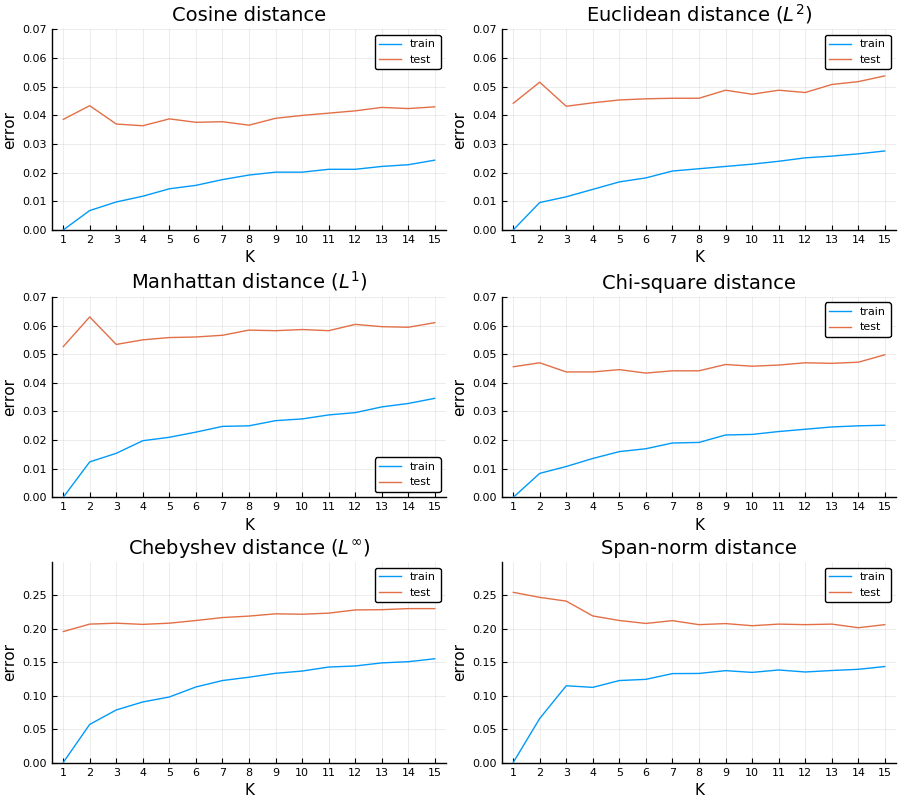

In [8]:
default(xlabel="K", ylabel="error",  ylims=(0, 0.07), xticks=1:num_ks)
pyplot(size=(900, 800))
plot(layout=(3,2))

train_costs, test_costs = costs_cosine
x_range = collect(1:length(train_costs))
plot!(x_range, hcat(train_costs, test_costs), title="Cosine distance", label=["train" "test"], subplot=1)

train_costs, test_costs = costs_euclidean
plot!(x_range, hcat(train_costs, test_costs), title="Euclidean distance ($(L"L^2"))", label=["train" "test"], subplot=2)

train_costs, test_costs = costs_chebyshev
plot!(x_range, hcat(train_costs, test_costs), title="Chebyshev distance ($(L"L^\infty"))", ylims=(0, 0.3), label=["train" "test"], subplot=5)

train_costs, test_costs = costs_chisq
plot!(x_range, hcat(train_costs, test_costs), title="Chi-square distance", label=["train" "test"], subplot=4)

train_costs, test_costs = costs_cityblock
plot!(x_range, hcat(train_costs, test_costs), title="Manhattan distance ($(L"L^1"))", label=["train" "test"], subplot=3)

train_costs, test_costs = costs_spannorm
plot!(x_range, hcat(train_costs, test_costs), title="Span-norm distance", ylims=(0, 0.3), label=["train" "test"], subplot=6)

Here we plot the accuracy (the fraction of correctly classified samples) on the test set for different distances and different values of `K `.

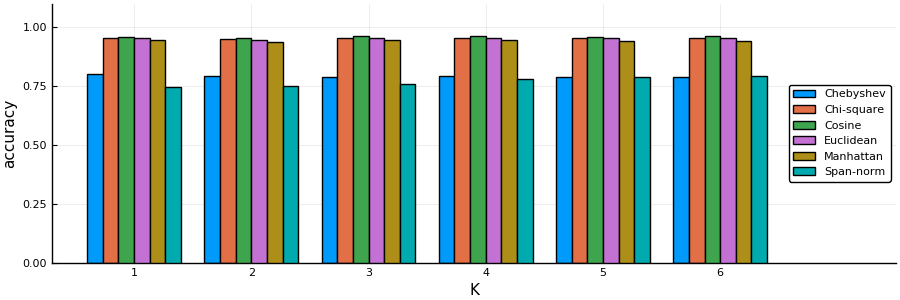

In [9]:
num_ks_groupedbar = min(6, num_ks) # we restrict the number of ks for better clarity.

all_test_accuracy = 1.0 .- hcat(costs_cosine[2], costs_euclidean[2], costs_cityblock[2], 
                                costs_chisq[2],  costs_chebyshev[2], costs_spannorm[2]);
all_test_accuracy = all_test_accuracy[1:num_ks_groupedbar, :]
all_names = ["Cosine",     "Euclidean", "Manhattan",
             "Chi-square", "Chebyshev", "Span-norm"]
ctg = repeat(all_names, inner=size(all_test_accuracy, 1));

pyplot(size=(900, 300))
#xlim has to be set a bit arbitrarily as otherwise the legend would overlap
groupedbar(all_test_accuracy,
           ylims=(0, 1.1),
           ylabel="accuracy",
           group=ctg,
           xticks=1:num_ks_groupedbar,
           xlim=(0.3, num_ks_groupedbar + 1.5),
           legend=:right)